In [1]:
# Imports and settings
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import xgboost as xgb
import random
import os
import shap

from joblib import dump
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

pd.set_option('display.float_format', '{:.6f}'.format)
random_seed = 909
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
# model_id = f'baseline_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
# dirname = f"outputs/{model_id}/"
# os.mkdir(dirname)

In [29]:
con = duckdb.connect("E:/duckdb/tennis.duckdb",read_only=True)
base_table = con.execute("SELECT * FROM base_table").df()
con.close()

In [139]:
target = 'winner_home'

exclude_cols = ['matchup_indices', 'tournament_name', 'datetime','match_players','pp_ltp_home','pp_ltp_away']
time_split_col = 'yyyymm'
cat_cols = ['groundType','tournament_category','tournament_points','tournament_round_category']
match_stat_cols = ['aces',	'backhandErrors',	'backhandUnforcedErrors',	'backhandWinners',	'breakPointsSaved',	'breakPointsScored',	'doubleFaults',	'dropShotUnforcedErrors',	'dropShotWinners',	'errorsTotal',	'firstReturnPoints',	'firstServeAccuracy',	'firstServePointsAccuracy',	'forehandErrors',	'forehandUnforcedErrors',	'forehandWinners',	'gamesWon',	'groundstrokeErrors',	'groundstrokeUnforcedErrors',	'groundstrokeWinners',	'lobUnforcedErrors',	'lobWinners',	'maxGamesInRow',	'maxPointsInRow',	'overheadStrokeErrors',	'overheadWinners',	'pointsTotal',	'receiverPointsScored',	'returnErrors',	'returnWinners',	'secondReturnPoints',	'secondServeAccuracy',	'secondServePointsAccuracy',	'serviceGamesTotal',	'serviceGamesWon',	'servicePointsScored',	'tiebreaks',	'unforcedErrorsTotal',	'volleyUnforcedErrors',	'volleyWinners',	'winnersTotal',	'breakPointsSavedAttempted',	'firstReturnPointsAttempted',	'firstServeAccuracyAttempted',	'firstServePointsAccuracyAttempted',	'secondReturnPointsAttempted',	'secondServeAccuracyAttempted',	'secondServePointsAccuracyAttempted']

for col in match_stat_cols:
    base_table[col] = pd.to_numeric(base_table[col])

In [ ]:
## Data cleaning steps

In [31]:
## Extra columns (pre-features)
# Bo5 or Bo3 indicator
# Number of games played, won (replace gamesWon), lost
score_columns = ['score_period1', 'score_period2', 'score_period3', 'score_period4', 'score_period5']
base_table['gamesWon'] = base_table[score_columns].sum(axis=1, skipna=True)
base_table['gamesPlayed'] = base_table.groupby('id')['gamesWon'].transform('sum')
base_table['gamesWonPct'] = base_table['gamesWon'] / base_table['gamesPlayed']
# First serve pct (firstServeAccuracy / firstServeAccuracyAttempted)
base_table['firstServePct'] = base_table['firstServeAccuracy'] / base_table['firstServeAccuracyAttempted']
# First serve points won pct (firstServePointsAccuracy / firstServeAccuracy)
base_table['firstServeWonPct'] = base_table['firstServePointsAccuracy'] / base_table['firstServeAccuracy']
# Second serve pct (secondServeAccuracy / secondServeAccuracyAttempted)
base_table['secondServePct'] = base_table['secondServeAccuracy'] / base_table['secondServeAccuracyAttempted']
# Second serve points won pct (secondServePointsAccuracy / secondServeAccuracy)
base_table['secondServeWonPct'] = base_table['secondServePointsAccuracy'] / base_table['secondServeAccuracy']
# Break points saved pct (breakPointsSaved / breakPointsSavedAttempted)
base_table['breakPointsSavedPct'] = base_table['breakPointsSaved'] / base_table['breakPointsSavedAttempted']
# Break points won pct (breakPointsScored / (breakPointsSaved_opponent + breakPointsScored))
# Assuming base_table is your DataFrame
base_table['breakPointsWonPct'] = base_table['breakPointsSaved'] / base_table.groupby('id')['breakPointsSaved'].transform('sum')

In [40]:
## Features (lagged pre-match)
# Career W/L
base_table = base_table.sort_values(['index', 'datetime'])
base_table['career_wins'] = base_table.groupby('index')['winner'].transform(
    lambda x: x.cumsum().shift(1).fillna(0)
)
base_table['career_matches'] = base_table.groupby('index').cumcount()
base_table['career_wl_pct'] = base_table['career_wins'] / base_table['career_matches']
# W/L on surface, tournament points, tournament category, tournament name
base_table['career_wins_surface'] = base_table.groupby(['index','groundType'])['winner'].transform(
    lambda x: x.cumsum().shift(1).fillna(0)
)
base_table['career_matches_surface'] = base_table.groupby(['index','groundType']).cumcount()
base_table['career_wl_pct_surface'] = base_table['career_wins_surface'] / base_table['career_matches_surface']

base_table['career_wins_tour_pts'] = base_table.groupby(['index','tournament_points'])['winner'].transform(
    lambda x: x.cumsum().shift(1).fillna(0)
)
base_table['career_matches_tour_pts'] = base_table.groupby(['index','tournament_points']).cumcount()
base_table['career_wl_pct_tour_pts'] = base_table['career_wins_tour_pts'] / base_table['career_matches_tour_pts']

base_table['career_wins_tour_cat'] = base_table.groupby(['index','tournament_round_category'])['winner'].transform(
    lambda x: x.cumsum().shift(1).fillna(0)
)
base_table['career_matches_tour_cat'] = base_table.groupby(['index','tournament_round_category']).cumcount()
base_table['career_wl_pct_tour_cat'] = base_table['career_wins_tour_cat'] / base_table['career_matches_tour_cat']

base_table['career_wins_tournament'] = base_table.groupby(['index','tournament_name'])['winner'].transform(
    lambda x: x.cumsum().shift(1).fillna(0)
)
base_table['career_matches_tournament'] = base_table.groupby(['index','tournament_name']).cumcount()
base_table['career_wl_pct_tournament'] = base_table['career_wins_tournament'] / base_table['career_matches_tournament']

In [ ]:
# W/L vs opponent, on surface, tournament points, tournament category, tournament name
base_table['matchup_indices'] = base_table.groupby('id')['index'].transform(lambda x: '|'.join(map(str, sorted(x))))
base_table['h2h_opponent_wins'] = base_table.groupby(['index', 'matchup_indices'])['winner'].transform(
    lambda x: x.cumsum().shift(1).fillna(0)
)
base_table['h2h_opponent_matches'] = base_table.groupby(['index', 'matchup_indices']).cumcount()
base_table['h2h_opponent_win_pct'] = base_table['h2h_opponent_wins'] / base_table['h2h_opponent_matches']

In [49]:
# W/L last 10, last 5
for window in [1, 3, 5, 10]:
    print(window)
    base_table[f'last_{window}_wins'] = base_table.groupby('index')['winner'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum().shift(1).fillna(0)
    )
    base_table[f'last_{window}_matches'] = base_table.groupby('index')['winner'].transform(
        lambda x: x.rolling(window=window, min_periods=1).count().shift(1).fillna(0)
    )
    base_table[f'last_{window}_wl_pct'] = base_table[f'last_{window}_wins'] / base_table[f'last_{window}_matches']

1
3
5
10


In [64]:
## Normalization ideas 
# Feature normed by ELO bracket and tournament category (i.e. how is my WL streak vs other similar ELO players (within ATP/WTA))

In [62]:
# Match stats with good coverage
# doubleFaults
# firstReturnPoints
# maxGamesInRow
# maxPointsInRow
# pointsTotal
# receiverPointsScored
# tiebreaks

In [322]:
features_to_pivot = ['pre_match_elo',
'career_wins',
'career_matches',
'career_wl_pct',
'career_wins_surface',
'career_matches_surface',
'career_wl_pct_surface',
'career_wins_tour_pts',
'career_matches_tour_pts',
'career_wl_pct_tour_pts',
'career_wins_tour_cat',
'career_matches_tour_cat',
'career_wl_pct_tour_cat',
'career_wins_tournament',
'career_matches_tournament',
'career_wl_pct_tournament',
'h2h_opponent_wins',
'h2h_opponent_matches',
'h2h_opponent_win_pct',
'last_1_wins',
'last_1_matches',
'last_1_wl_pct',
'last_3_wins',
'last_3_matches',
'last_3_wl_pct',
'last_5_wins',
'last_5_matches',
'last_5_wl_pct',
'last_10_wins',
'last_10_matches',
'last_10_wl_pct',
'winner',
'clean_name','pp_ltp']

match_cols = ['matchup_indices','tournament_name','datetime','groundType','tournament_category','tournament_points','tournament_round_category']

home_df = base_table[base_table['position'] == 'home'].copy()
away_df = base_table[base_table['position'] == 'away'].copy()

# Step 2: Rename columns for home and away
home_columns = {col: f'{col}_home' for col in features_to_pivot}
away_columns = {col: f'{col}_away' for col in features_to_pivot}

home_df = home_df.rename(columns=home_columns)
away_df = away_df.rename(columns=away_columns)

# Step 3: Set index for merging
home_df.set_index('id', inplace=True)
away_df.set_index('id', inplace=True)

# Step 4: Merge home and away data
merged_df = pd.merge(home_df[list(home_columns.values())], away_df[list(away_columns.values())], left_index=True, right_index=True)

In [323]:
match_cols_df = base_table[['id'] + match_cols].drop_duplicates()
match_cols_df.set_index('id',inplace=True)

In [324]:
base_table_pivoted = merged_df.merge(match_cols_df, left_index=True, right_index=True)
base_table_pivoted['match_players'] = base_table_pivoted['clean_name_home'] + ' v ' + base_table_pivoted['clean_name_away']
base_table_pivoted.drop(columns=['winner_away','clean_name_home','clean_name_away'], inplace=True) # winner_home is the target

In [325]:
# TODO: Instead of using index as the grouping for features for missing mappings, use the player name

In [326]:
for col in [x for x in features_to_pivot if x not in ['winner','clean_name','pp_ltp']]:
    if col == 'pre_match_elo':
        base_table_pivoted[f'{col}_diff'] = base_table_pivoted[f'{col}_home'] - base_table_pivoted[f'{col}_away']
    else:
        base_table_pivoted[f'{col}_ha_ratio'] = base_table_pivoted[f'{col}_home'] / base_table_pivoted[f'{col}_away']

In [327]:
base_table_pivoted = base_table_pivoted.replace([np.inf, -np.inf], np.nan)

In [328]:
base_table_pivoted['yyyymm'] = (base_table_pivoted['datetime'].dt.year * 100 + base_table_pivoted['datetime'].dt.month).astype(int)

In [329]:
for col in cat_cols:
    base_table_pivoted[col] = base_table_pivoted[col].astype('category')

In [330]:
# TODO: Below doesn't improve model - try home/away unknown indicator instead
# base_table_pivoted['unknown_player'] = base_table_pivoted['matchup_indices'].str.startswith('-1').astype(int)

In [331]:
# Run model
folds = base_table_pivoted.query('yyyymm < 202409').sort_values('datetime')['yyyymm'].unique()[-12:]

df_train = base_table_pivoted.copy()
feature_cols = [x for x in df_train.columns if x not in [target] + exclude_cols + [time_split_col]]

# Prepare data
X_train = df_train[feature_cols]
y_train = df_train[target]
seasons_train = df_train[time_split_col]  # Assuming 'season' is the column name for years

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'device': 'cuda',
    'tree_method': 'hist',
    'seed': random_seed,
    'eta': 0.025,
    'max_depth': 7,
    'subsample': 0.85,
    'colsample_bylevel': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 1.835341042518789,
    'lambda': 7.009535557334815,
    'alpha': 1.1975316744933502,
}

# Initialize models list and predictions array
models = []
fold_metrics = []
validation_predictions = []

# Existing code for all folds (2019-2023)
for fold, val_fold in enumerate(folds, 1):
    print(f"Fold {fold}")

    # Split data
    train_mask = seasons_train < val_fold
    val_mask = seasons_train == val_fold

    X_fold_train, y_fold_train = X_train[train_mask], y_train[train_mask]
    X_val, y_val = X_train[val_mask], y_train[val_mask]

    # Train XGBoost
    dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train, feature_names=feature_cols, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_cols, enable_categorical=True)
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=700, evals=[(dtrain,'train'),(dval, 'val')], verbose_eval=100)
    
    xgb_pred = xgb_model.predict(dval)

    df_val = df_train[val_mask].copy()
    df_val['prediction'] = xgb_pred
    betfair_only = df_val.query('~pp_ltp_home.isna() and ~pp_ltp_away.isna()').copy()
    betfair_only['pred_price_home'] = 1 / betfair_only['prediction']
    betfair_only['pred_price_away'] = 1 / (1 - betfair_only['prediction'])
    
    betfair_only['home_bet'] = (betfair_only['pred_price_home'] < betfair_only['pp_ltp_home']).astype(int)
    betfair_only['away_bet'] = (betfair_only['pred_price_away'] < betfair_only['pp_ltp_away']).astype(int)
    betfair_only['profit'] = 0.0
    betfair_only.loc[(betfair_only['home_bet'] == 1) & (betfair_only['winner_home'] == 1), 'profit'] = 10.0 * (
                betfair_only['pp_ltp_home'] - 1.0)
    betfair_only.loc[(betfair_only['away_bet'] == 1) & (betfair_only['winner_home'] == 1), 'profit'] = -10.0
    betfair_only.loc[(betfair_only['home_bet'] == 1) & (betfair_only['winner_home'] == 0), 'profit'] = -10.0
    betfair_only.loc[(betfair_only['away_bet'] == 1) & (betfair_only['winner_home'] == 0), 'profit'] = 10.0 * (
                betfair_only['pp_ltp_away'] - 1.0)
    roi = betfair_only['profit'].sum() / (len(betfair_only) * 10)
    log_loss_fold = log_loss(df_val['winner_home'],df_val['prediction'])
    
    betfair_only['home_bet_elo'] = 0
    betfair_only.loc[betfair_only['pre_match_elo_home'] > betfair_only['pre_match_elo_away'], 'home_bet_elo'] = 1
    betfair_only['away_bet_elo'] = 0
    betfair_only.loc[betfair_only['pre_match_elo_home'] < betfair_only['pre_match_elo_away'], 'away_bet_elo'] = 1
    
    betfair_only['profit_elo'] = 0.0
    betfair_only.loc[
        (betfair_only['home_bet_elo'] == 1) & (betfair_only['winner_home'] == 1), 'profit_elo'] = 10.0 * (
            betfair_only['pp_ltp_home'] - 1.0)
    betfair_only.loc[
        (betfair_only['away_bet_elo'] == 1) & (betfair_only['winner_home'] == 1), 'profit_elo'] = -10.0
    betfair_only.loc[
        (betfair_only['home_bet_elo'] == 1) & (betfair_only['winner_home'] == 0), 'profit_elo'] = -10.0
    betfair_only.loc[
        (betfair_only['away_bet_elo'] == 1) & (betfair_only['winner_home'] == 0), 'profit_elo'] = 10.0 * (
            betfair_only['pp_ltp_away'] - 1.0)
    roi_elo = betfair_only['profit_elo'].sum() / (len(betfair_only) * 10)
    
    models.append({
        'fold': val_fold,
        'model': xgb_model
    })
    
    fold_metrics.append({
        'fold': val_fold,
        'roi': roi,
        'roi_elo': roi_elo,
        'log_loss': log_loss_fold
    })
    
    validation_predictions.append({
        'val': df_val,
        'bf_only': betfair_only
    })
    
    print(f"Fold: {str(val_fold)} | ROI: {(roi*100):.3f}% | ROI (Elo comparison only): {(roi_elo*100):.3f}% | Log Loss: {log_loss_fold:.5f}")

Fold 1
[0]	train-logloss:0.68656	val-logloss:0.68507
[100]	train-logloss:0.56368	val-logloss:0.55172
[200]	train-logloss:0.55474	val-logloss:0.54552
[300]	train-logloss:0.54982	val-logloss:0.54363
[400]	train-logloss:0.54604	val-logloss:0.54289
[500]	train-logloss:0.54318	val-logloss:0.54247
[600]	train-logloss:0.54065	val-logloss:0.54235
[699]	train-logloss:0.53829	val-logloss:0.54213
Fold: 202309 | ROI: -1.293% | ROI (Elo comparison only): 1.335% | Log Loss: 0.54213
Fold 2
[0]	train-logloss:0.68656	val-logloss:0.68578
[100]	train-logloss:0.56349	val-logloss:0.54849
[200]	train-logloss:0.55463	val-logloss:0.54186
[300]	train-logloss:0.54980	val-logloss:0.54008
[400]	train-logloss:0.54627	val-logloss:0.53938
[500]	train-logloss:0.54331	val-logloss:0.53911
[600]	train-logloss:0.54066	val-logloss:0.53878
[699]	train-logloss:0.53829	val-logloss:0.53862
Fold: 202310 | ROI: 6.293% | ROI (Elo comparison only): -2.960% | Log Loss: 0.53862
Fold 3
[0]	train-logloss:0.68654	val-logloss:0.68696
[

In [332]:
all_validation_bf = pd.concat([x['bf_only'] for x in validation_predictions])
all_validation = pd.concat([x['val'] for x in validation_predictions])
all_val_roi = all_validation_bf['profit'].sum() / (len(all_validation_bf) * 10)
all_val_roi_elo = all_validation_bf['profit_elo'].sum() / (len(all_validation_bf) * 10)

all_val_log_loss_bf = log_loss(all_validation_bf['winner_home'], all_validation_bf['prediction'])
all_val_log_loss = log_loss(all_validation['winner_home'], all_validation['prediction'])

print(f'Out-of-fold ROI: {(all_val_roi*100):.3f}% | Elo comparison only ROI: {(all_val_roi_elo*100):.3f}% | Log Loss (BF only): {all_val_log_loss_bf:.5f} | Log Loss: {all_val_log_loss:.5f}')

Out-of-fold ROI: -0.324% | Elo comparison only ROI: -0.686% | Log Loss (BF only): 0.60365 | Log Loss: 0.54052


In [333]:
for fm in fold_metrics:
    print(f"Fold: {str(fm['fold'])} | ROI: {(fm['roi']*100):.3f}% | ROI (Elo comparison only): {(fm['roi_elo']*100):.3f}% | Log Loss: {fm['log_loss']:.5f}")

Fold: 202309 | ROI: -1.293% | ROI (Elo comparison only): 1.335% | Log Loss: 0.54213
Fold: 202310 | ROI: 6.293% | ROI (Elo comparison only): -2.960% | Log Loss: 0.53862
Fold: 202311 | ROI: 2.195% | ROI (Elo comparison only): 2.083% | Log Loss: 0.54031
Fold: 202312 | ROI: 11.094% | ROI (Elo comparison only): -7.160% | Log Loss: 0.51251
Fold: 202401 | ROI: 0.368% | ROI (Elo comparison only): -1.944% | Log Loss: 0.54752
Fold: 202402 | ROI: -0.842% | ROI (Elo comparison only): -0.319% | Log Loss: 0.54341
Fold: 202403 | ROI: -0.237% | ROI (Elo comparison only): 0.971% | Log Loss: 0.53161
Fold: 202404 | ROI: 1.274% | ROI (Elo comparison only): 0.220% | Log Loss: 0.53764
Fold: 202405 | ROI: -6.374% | ROI (Elo comparison only): -0.686% | Log Loss: 0.53992
Fold: 202406 | ROI: -0.415% | ROI (Elo comparison only): -1.312% | Log Loss: 0.55239
Fold: 202407 | ROI: -2.783% | ROI (Elo comparison only): -0.443% | Log Loss: 0.54533
Fold: 202408 | ROI: -1.944% | ROI (Elo comparison only): -2.692% | Log Lo

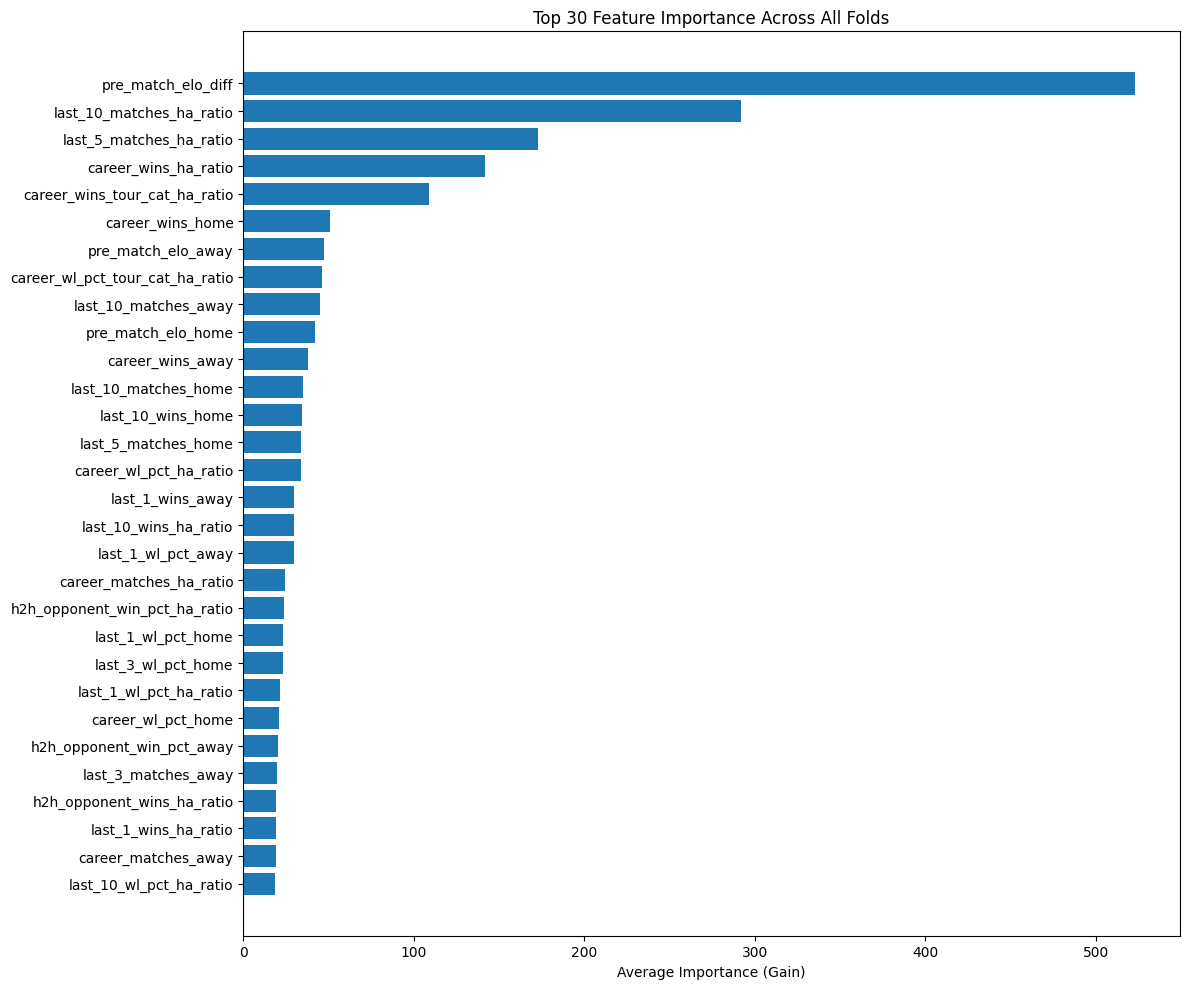

In [334]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate feature importance for each model
feature_importance_list = []
for model_info in models:
    xgb_model = model_info['model']
    feature_importance = xgb_model.get_score(importance_type='gain')
    feature_importance_list.append(feature_importance)

# Calculate average feature importance across all models
avg_feature_importance = {}
for feature in feature_cols:
    avg_feature_importance[feature] = np.mean([fold_importance.get(feature, 0) for fold_importance in feature_importance_list])

# Sort features by importance
sorted_features = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Create a horizontal bar chart of feature importance
plt.figure(figsize=(12, 10))
features, importance = zip(*sorted_features[:30])  # Get top 20 features
y_pos = np.arange(len(features))

plt.barh(y_pos, importance)
plt.yticks(y_pos, features)
plt.xlabel('Average Importance (Gain)')
plt.title('Top 30 Feature Importance Across All Folds')
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.tight_layout()
plt.show()